In [3]:
from scipy.stats import gamma, norm
import numpy as np
import pandas
import math
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as pyplot
from forecasters.lv_mobility import LVMM
from plots import plot_fit

# Load data

In [4]:
"""
Loading datasets and defining variables for use. The data here is aggregated into weekly data points.

State - two letter abbreviations for state
Y - death count for that week
A - proportion that stay at home, sum of weekly values
C - case count for that week
"""
def we(a):
    n = len(a)
    b = math.floor(n/7)
    nn = b*7
    a = a[0:nn]
    a = a.values.reshape((b, 7))
    a = np.sum(a, axis=1)
    a = a.reshape((1, b))
    return a

df = pandas.read_csv(os.path.join(os.getcwd(), "data/state_full.csv"))
df = df[df["state"] != "pr"]

date = df["date"]
deaths = df["ndeaths"]
home = df["completely_home_prop"]
work = df["full_time_work_prop"]
part = df["part_time_work_prop"]
median = df["median_home_dwell_time"]
cases = df["ncases"]
state = df["state"]
State = pandas.unique(state)
deaths[deaths < 0] = 0

Y = A = C = None
n = len(deaths)
for i in range(0, 51):
    if i == 0:
        I = (state == State[i])
        Y = we(deaths[I])
        A = we(home[I])  # using HOME
        C = we(cases[I])
    else:
        I = (state == State[i])
        Y = np.concatenate([Y, we(deaths[I])])
        A = np.concatenate([A, we(home[I])])  # using HOME
        C = np.concatenate([C, we(cases[I])])

In [5]:
df.columns

Index(['state', 'date', 'ncases', 'ndeaths', 'completely_home_prop',
       'full_time_work_prop', 'part_time_work_prop', 'median_home_dwell_time',
       'population', 'male', 'female', 'black', 'hispanic', 'age_00_04',
       'age_05_09', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29',
       'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54',
       'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79',
       'age_80_84', 'age_85_older', 'chr_population', 'chr_premature_death',
       'chr_poor_or_fair_health', 'chr_poor_physical_health_days',
       'chr_poor_mental_health_days', 'chr_low_birthweight',
       'chr_adult_smoking', 'chr_adult_obesity', 'chr_food_environment_index',
       'chr_physical_inactivity', 'chr_access_to_exercise_opportunities',
       'chr_excessive_drinking', 'chr_alcohol.impaired_driving_deaths',
       'chr_sexually_transmitted_infections', 'chr_teen_births',
       'chr_uninsured', 'chr_primary_care_physicians', 'chr_dentists

# Test individual states

In [6]:
#initialize death curve
l = 25 #length of time interval
t = np.linspace(start=0, stop=l, num=l+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']

#intialize your mobility time series by selecting the index for your state
i=2

model = LVMM()
y_true = C[i, :l]
m = A[i, :l]

In [7]:
#Fit model
model.fit(
    M=m,
    DC=ft[:l],
    y_true=y_true,
)

y_pred = model.preds

/home/xiavatar/Projects/hdt-forecast/forecasters/forecasters/lv_mobility/model.py:78: RuntimeWarning: overflow encountered in exp
  out = out + DC0*np.exp(BetaSum[d])
/home/xiavatar/Projects/hdt-forecast/forecasters/forecasters/lv_mobility/model.py:78: RuntimeWarning: invalid value encountered in multiply
  out = out + DC0*np.exp(BetaSum[d])


In [6]:
model.args

{'A': 100.0,
 'alpha': -0.5351225383350752,
 'beta': 0.7231356704893955,
 'mu': 1.6607594307338394,
 'sig': 1e-05,
 'M': array([1.46104406, 1.5200612 , 1.61381331, 1.52605252, 1.62909915,
        1.41461628, 1.38812132, 1.70223098, 2.13268644, 2.09180085,
        2.35881594, 2.2888028 , 2.12219974, 2.04254759, 1.97069726,
        1.87603477, 1.89833498, 1.82973018, 1.66883969, 1.68060034,
        1.73970589, 1.66083983, 1.68143694, 1.73931048, 1.70240086]),
 'DC': array([0.00000000e+00, 1.36714677e-03, 7.76375499e-03, 9.65277033e-03,
        6.44387054e-03, 3.05949663e-03, 1.17096863e-03, 3.86226987e-04,
        1.14250576e-04, 3.11001170e-05, 7.92829637e-06, 1.91668859e-06,
        4.43499836e-07, 9.89135272e-08, 2.13800699e-08, 4.49814286e-09,
        9.24364395e-10, 1.86070836e-10, 3.67760546e-11, 7.15094810e-12,
        1.37025468e-12, 2.59118903e-13, 4.84162646e-14, 8.94830551e-15,
        1.63738757e-15])}

Text(0.5, 1.0, 'ar')

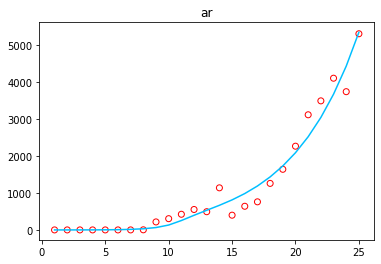

In [7]:
# plotting predictions and observations for State[i]
pyplot.scatter(x[:l],y_true[:l],facecolors="none", edgecolors="r")
pyplot.plot(x[:l],y_pred, color='deepskyblue')
pyplot.title(State[i])

In [107]:
l2 = 25
 
t = np.linspace(start=0, stop=l2, num=l2+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l2+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']

# training loop
i=2

y_true = Y[i, :l2]

forecast = model.forecast(
    l=l2,
)
forecast_real = model.forecast(
    l=l2,
    M=A[i,:l2]
)

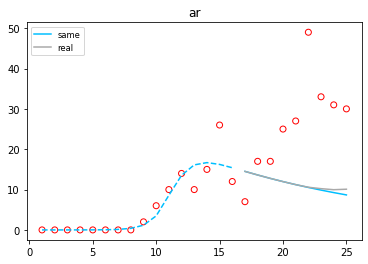

In [108]:
# plotting predictions and observations for State[i]
pyplot.scatter(x,y_true,facecolors="none", edgecolors="r")
pyplot.plot(x[:l],forecast[:l],linestyle='--',color='deepskyblue')
pyplot.plot(x[l:],forecast[l:],color='deepskyblue', label='same')
pyplot.plot(x[l:],forecast_real[l:],color='darkgrey', label='real')
pyplot.title(State[i])
pyplot.legend(fontsize='small')

# Test for global parameters

Can parameters trained on national level data generalize to fit models on local data?

In [82]:
Y_global = Y.mean(axis=0)
A_global = A.mean(axis=0)

In [83]:
#initialize death curve
l = 18 #length of time interval
t = np.linspace(start=0, stop=l, num=l+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']

model_global = LVMM()
y_true = Y_global[:l]
m = A_global[:l]

In [84]:
#Fit model
model_global.fit(
    M=m,
    DC=ft[:l],
    y_true=y_true,
)

y_pred = model_global.preds

/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: overflow encountered in exp
  out = out + DC0*numpy.exp(BetaSum[d])
/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: invalid value encountered in multiply
  out = out + DC0*numpy.exp(BetaSum[d])


In [85]:
model_global.args

{'A': -2.1572300913017317,
 'alpha': -1.48865800103204,
 'beta': 1.2693293476428016,
 'mu': 1.829624948443211,
 'sig': 0.000565548845012468,
 'M': array([1.59135849, 1.69588091, 1.8062904 , 1.70288027, 1.77383164,
        1.63931007, 1.55674433, 1.86226027, 2.45690198, 2.59044121,
        2.88250739, 2.87095749, 2.71652831, 2.55703033, 2.55620104,
        2.49637179, 2.395036  , 2.28157631]),
 'DC': array([0.00000000e+00, 1.36714677e-03, 7.76375499e-03, 9.65277033e-03,
        6.44387054e-03, 3.05949663e-03, 1.17096864e-03, 3.86226987e-04,
        1.14250576e-04, 3.11001170e-05, 7.92829637e-06, 1.91668859e-06,
        4.43499836e-07, 9.89135272e-08, 2.13800699e-08, 4.49814286e-09,
        9.24364396e-10, 1.86070836e-10])}

Text(0.5, 1.0, 'National')

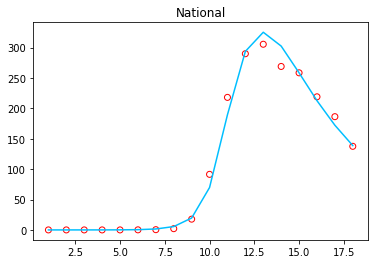

In [86]:
# plotting predictions and observations for State[i]
pyplot.scatter(x[:l],y_true[:l],facecolors="none", edgecolors="r")
pyplot.plot(x[:l],y_pred, color='deepskyblue')
pyplot.title('National')

In [94]:
l2 = 25
 
t = np.linspace(start=0, stop=l2, num=l2+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l2+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']

y_true = Y_global[:l2]

forecast = model_global.forecast(
    l=l2,
)
forecast_real = model_global.forecast(
    l=l2,
    M=A_global[:l2]
)

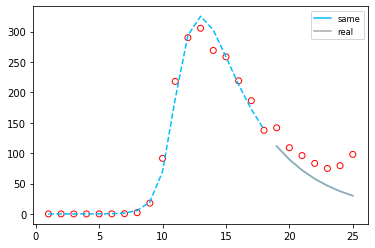

In [95]:
# plotting predictions and observations for State[i]
pyplot.scatter(x,y_true,facecolors="none", edgecolors="r")
pyplot.plot(x[:l],forecast[:l],linestyle='--',color='deepskyblue')
pyplot.plot(x[l:],forecast[l:],color='deepskyblue', label='same')
pyplot.plot(x[l:],forecast_real[l:],color='darkgrey', label='real')
pyplot.legend(fontsize='small')

In [96]:
i=10
l2 = 21
 
t = np.linspace(start=0, stop=l2, num=l2+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l2+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']


y_true = Y[i,:l2]

forecast = model_global.forecast(
    l=l2,
    M=list(A[i,:l2])
)
forecast_real = model_global.forecast(
    l=l2,
    M=A[i,:l2]
)

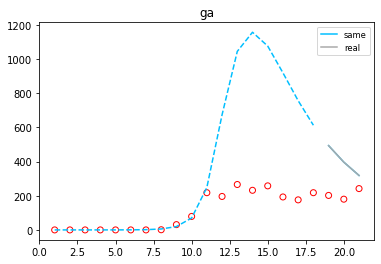

In [98]:
# plotting predictions and observations for State[i] using parameters fitted for national level data
pyplot.scatter(x,y_true,facecolors="none", edgecolors="r")
pyplot.plot(x[:l],forecast[:l],linestyle='--',color='deepskyblue')
pyplot.plot(x[l:],forecast[l:],color='deepskyblue', label='same')
pyplot.plot(x[l:],forecast_real[l:],color='darkgrey', label='real')
pyplot.title(State[i])
pyplot.legend(fontsize='small')

# Fitting to random data, model capacity

Here we just want to examine the model's capacity. If given actual death counts but completely randomized mobility data, will the model still be able to fit the data?

In [31]:
i=33
l = 25 #length of time interval
t = np.linspace(start=0, stop=l, num=l+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']

model_random = LVMM()
y_true = Y[i, :l]
m = np.random.uniform(0.5, 3, l)

In [32]:
#Fit model
model_random.fit(
    M=m,
    DC=ft[:l],
    y_true=y_true,
)

y_pred = model_random.preds

/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: overflow encountered in exp
  out = out + DC0*numpy.exp(BetaSum[d])
/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: invalid value encountered in multiply
  out = out + DC0*numpy.exp(BetaSum[d])


In [34]:
model_random.args

{'A': 73.58162031432292,
 'alpha': -1.5543557926553164,
 'beta': 1.2831724926790635,
 'mu': -1.4843567324451632,
 'sig': 0.0077230399577061775,
 'M': array([2.33656425, 2.63636011, 1.33422771, 2.09555233, 0.71770628,
        2.14608021, 0.50354399, 1.74091942, 0.55557108, 2.98760198,
        2.19746059, 2.56861457, 2.51622738, 2.20324695, 2.71750241,
        1.49645048, 2.02106773, 1.31115447, 2.11888347, 2.2645551 ,
        1.43899077, 1.42941706, 0.72899315, 1.6266523 , 2.35309067]),
 'DC': array([0.00000000e+00, 1.36714677e-03, 7.76375499e-03, 9.65277033e-03,
        6.44387054e-03, 3.05949663e-03, 1.17096863e-03, 3.86226987e-04,
        1.14250576e-04, 3.11001170e-05, 7.92829637e-06, 1.91668859e-06,
        4.43499836e-07, 9.89135272e-08, 2.13800699e-08, 4.49814286e-09,
        9.24364395e-10, 1.86070836e-10, 3.67760546e-11, 7.15094810e-12,
        1.37025468e-12, 2.59118903e-13, 4.84162646e-14, 8.94830551e-15,
        1.63738757e-15])}

Text(0.5, 1.0, 'nv')

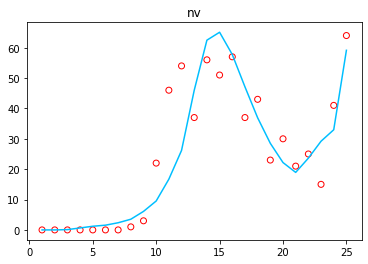

In [33]:
# plotting predictions and observations for State[i]
pyplot.scatter(x[:l],y_true[:l],facecolors="none", edgecolors="r")
pyplot.plot(x[:l],y_pred, color='deepskyblue')
pyplot.title(State[i])

In [35]:
i=44
l = 25 #length of time interval
t = np.linspace(start=0, stop=l, num=l+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']

model_random = LVMM()
y_true = Y[i, :l]
m = np.random.uniform(0.5, 3, l)

In [36]:
#Fit model
model_random.fit(
    M=m,
    DC=ft[:l],
    y_true=y_true,
)

y_pred = model_random.preds

/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: overflow encountered in exp
  out = out + DC0*numpy.exp(BetaSum[d])
/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: invalid value encountered in multiply
  out = out + DC0*numpy.exp(BetaSum[d])


In [37]:
model_random.args

{'A': -3.8421209266704013,
 'alpha': -4.0,
 'beta': 4.0483247873101185,
 'mu': -0.8197864962172766,
 'sig': 1e-05,
 'M': array([2.47241657, 2.49607071, 2.35469661, 2.49320828, 0.75353697,
        1.8698989 , 1.19903174, 1.1375589 , 1.71325893, 1.24527952,
        1.57368086, 1.00382636, 1.12012708, 2.18774633, 2.85712593,
        2.1808243 , 1.47274212, 0.95855026, 2.29509401, 1.91382683,
        2.65911529, 2.1029468 , 1.74458222, 0.57828456, 0.97402335]),
 'DC': array([0.00000000e+00, 1.36714677e-03, 7.76375499e-03, 9.65277033e-03,
        6.44387054e-03, 3.05949663e-03, 1.17096863e-03, 3.86226987e-04,
        1.14250576e-04, 3.11001170e-05, 7.92829637e-06, 1.91668859e-06,
        4.43499836e-07, 9.89135272e-08, 2.13800699e-08, 4.49814286e-09,
        9.24364395e-10, 1.86070836e-10, 3.67760546e-11, 7.15094810e-12,
        1.37025468e-12, 2.59118903e-13, 4.84162646e-14, 8.94830551e-15,
        1.63738757e-15])}

Text(0.5, 1.0, 'ut')

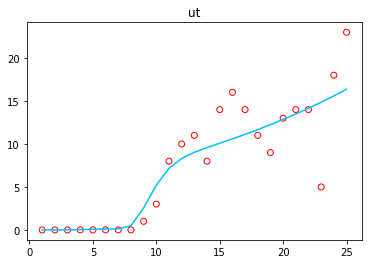

In [38]:
# plotting predictions and observations for State[i]
pyplot.scatter(x[:l],y_true[:l],facecolors="none", edgecolors="r")
pyplot.plot(x[:l],y_pred, color='deepskyblue')
pyplot.title(State[i])

In [45]:
l = 25 #length of time interval
t = np.linspace(start=0, stop=l, num=l+1)
ft = gamma.pdf(t*7, scale=3.64, a=6.28)  # a - shape parameter
ft = (ft/sum(ft)) * 0.03
x = range(1, l+1)

keys = ['A', 'alpha', 'beta', 'mu', 'sig']

model_random = LVMM()
y_true = np.concatenate([[0,0,0,10,30],[50,90,70,30,20],[10,5,1,100, 120],[200,150,40,20,10],[5, 2,1,1,1]])
m = np.random.uniform(0.5, 3, l)

In [46]:
#Fit model
model_random.fit(
    M=m,
    DC=ft[:l],
    y_true=y_true,
)

y_pred = model_random.preds

/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: overflow encountered in exp
  out = out + DC0*numpy.exp(BetaSum[d])
/home/xiavatar/Projects/hdt-forecast/hdt_models/lv_mobility/model.py:78: RuntimeWarning: invalid value encountered in multiply
  out = out + DC0*numpy.exp(BetaSum[d])


In [47]:
model_random.args

{'A': 100.0,
 'alpha': 4.0,
 'beta': -2.103404628039803,
 'mu': -2.0,
 'sig': 0.5104442778682887,
 'M': array([1.22548715, 2.84858734, 1.93319756, 1.78890097, 2.9027985 ,
        2.42927239, 1.31952647, 2.84761203, 2.55585772, 2.68422947,
        0.60950715, 2.08921121, 2.09752972, 2.00504024, 0.86380359,
        2.73084585, 1.82257712, 0.88002517, 1.96095591, 1.43812955,
        0.61897238, 2.41012376, 1.85268952, 1.31639871, 1.72926454]),
 'DC': array([0.00000000e+00, 1.36714677e-03, 7.76375499e-03, 9.65277033e-03,
        6.44387054e-03, 3.05949663e-03, 1.17096863e-03, 3.86226987e-04,
        1.14250576e-04, 3.11001170e-05, 7.92829637e-06, 1.91668859e-06,
        4.43499836e-07, 9.89135272e-08, 2.13800699e-08, 4.49814286e-09,
        9.24364395e-10, 1.86070836e-10, 3.67760546e-11, 7.15094810e-12,
        1.37025468e-12, 2.59118903e-13, 4.84162646e-14, 8.94830551e-15,
        1.63738757e-15])}

Text(0.5, 1.0, 'Completely random data')

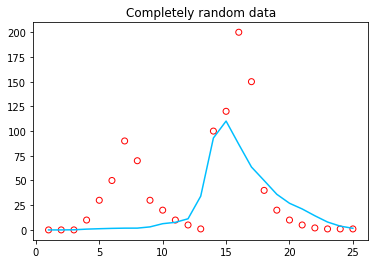

In [49]:
# plotting predictions and observations for State[i]
pyplot.scatter(x[:l],y_true[:l],facecolors="none", edgecolors="r")
pyplot.plot(x[:l],y_pred, color='deepskyblue')
pyplot.title('Completely random data')

In [50]:
A[i,:]

array([1.53077529, 1.71758611, 1.67322722, 1.60060381, 1.68249347,
       1.58981528, 1.47442749, 1.81833163, 2.43226606, 2.51737309,
       2.8576751 , 2.72437219, 2.64274579, 2.38722097, 2.43468992,
       2.29557516, 2.27419232, 2.16997215, 2.13210046, 2.13948566,
       2.19904896, 2.0644211 , 2.10452867, 2.06210378, 2.09820081,
       2.11447284,        nan])